# Tercer Examen Parcial (Práctico)
### Laboratorio de Aprendizaje Estadístico

José Armando Melchor Soto  | 745697

--- 




### Librerías: 

In [1050]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
import warnings
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
import xgboost as xgb 
from xgboost import  XGBRegressor, XGBClassifier, plot_importance as xgb_plot_importance, callback as xgb_callback
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb
from lightgbm import LGBMRegressor,LGBMClassifier, plot_importance,early_stopping, log_evaluation

warnings.simplefilter(action='ignore', category=FutureWarning)

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

---

### Dataset : 
Diabetes

In [1051]:
df = pd.read_csv('diabetes.csv')

In [1052]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0


#### Dummies

In [1053]:
df = pd.get_dummies(df, drop_first=True)
df

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,0,False,False,False,False,False,False,False
99996,2.0,0,0,17.37,0,False,False,False,False,False,False,False
99997,66.0,0,0,27.83,0,True,False,False,False,True,False,False
99998,24.0,0,0,35.42,0,False,False,False,False,False,True,False


### Visualización del Dataset

In [1054]:
df.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False


In [1055]:
print(df.columns)


Index(['age', 'hypertension', 'heart_disease', 'bmi', 'diabetes',
       'gender_Male', 'gender_Other', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current'],
      dtype='object')


### Explicación de las variables

`gender`: Básicamente indica el sexo biológico del paciente.

`age`: Edad

`hypertension`: Dice si tiene hipertensión o no.


`heart_disease`: Dice si tiene una enfermedad en el corazón o no.

`smoking_history`: Dice si ha fumado o no.

`never`: Nunca ha fumado.

`current`: Actualmente fuma.

`No Info`: No se tiene información sobre su historial de tabaquismo.

`bmi`: Un indicador del peso en relación a la altura.

`diabetes`: Dice si tiene diabetes o no.

---

#### Se busca predecir

In [1056]:
target= 'diabetes'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### NaN's

In [1057]:
pd.DataFrame(df.isnull().sum()).T

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,0,0,0,0,0,0,0,0,0,0,0,0


Ninguna Variable tiene NaN's , así que podemos continuar

### **Funciones**

##### Función Calibración 

In [1058]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False) + 1
    gropuped = df_calibracion.groupby('bins').mean()
    
    plt.plot(gropuped.predicciones, gropuped.y, label="Modelo", marker="o")
    plt.plot(gropuped.predicciones, gropuped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

##### Función Bivariado

In [1059]:
def bivariado(df):
    num_features = df.iloc[:, :].columns
    df_numerical = df.iloc[:, :].copy()

    for feature in num_features:
        df_numerical[f'{feature}_bins'] = pd.qcut(df_numerical[feature], q=5, labels=False, duplicates='drop')

        if df_numerical[f'{feature}_bins'].isna().sum() > 0:
            print(f"Advertencia: {feature} tiene valores NaN en la segmentación.")

        grouped = df_numerical.groupby(f'{feature}_bins').mean()

        fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 
        
        sns.lineplot(x=grouped[feature], y=grouped[target], marker='o', color='#b30000', ax=axes[0])
        axes[0].set_title(f'Relación de {feature} con {target}')
        axes[0].set_xlabel(feature)
        axes[0].set_ylabel(target)
        axes[0].grid()

        sns.histplot(df_numerical[feature], bins=50, color='#b30000', edgecolor='black', kde=True, ax=axes[1])
        axes[1].set_title(f'Distribución de {feature}')
        axes[1].set_xlabel(feature)
        axes[1].set_ylabel('Frecuencia')

        plt.show()


##### Función Lightgbm

In [1060]:
def lightgbm(X_train, y_train, X_test, y_test):
    model_lightgbm = LGBMClassifier(
        n_estimators=10000,
        num_leaves=10,
        learning_rate=0.1,
        max_depth=20,
        reg_lambda=0.1,
        subsample=0.5,
        colsample_bytree=0.8,
        verbosity=-1
    )
    model_lightgbm.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='auc',
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(period=100)
        ]
    )
    proba_lightgbm = model_lightgbm.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, proba_lightgbm)
    print("AUC LightGBM:", auc_score)

    fpr, tpr, _ = roc_curve(y_test, proba_lightgbm)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'LightGBM (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - LightGBM')
    plt.legend()
    plt.grid(True)
    plt.show()

    juntar = pd.DataFrame({
        'real': y_test,
        'probabilidades': proba_lightgbm
    })

    plot_importance(model_lightgbm, max_num_features=5, importance_type='split')
    plot_importance(model_lightgbm, max_num_features=5, importance_type='gain')

    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label='1')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label='0')
    plt.title('Histograma de probabilidades LightGBM')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.show()

    return proba_lightgbm


##### Función CatBoost

In [1061]:
def catboost(X_train, y_train, X_test, y_test):
    cat_cols = [col for col in X_train.columns if X_train[col].nunique() < 50]
    for col in cat_cols:
        X_train[col] = X_train[col].astype(str).fillna('missing')
        X_test[col] = X_test[col].astype(str).fillna('missing')

    model_catboost = CatBoostClassifier(
        iterations=10000,
        depth=5,
        learning_rate=0.1,
        subsample=0.5,
        rsm=0.8,
        eval_metric='AUC',
        verbose=100,
        early_stopping_rounds=50
    )
    model_catboost.fit(X_train, y_train, cat_features=cat_cols, eval_set=(X_test, y_test))
    proba_catboost = model_catboost.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, proba_catboost)
    print("AUC CatBoost:", auc_score)

    fpr, tpr, _ = roc_curve(y_test, proba_catboost)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'CatBoost (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - CatBoost')
    plt.legend()
    plt.grid(True)
    plt.show()

    juntar = pd.DataFrame({
        'real': y_test,
        'probabilidades': proba_catboost
    })

    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label='1')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label='0')
    plt.title('Histograma de probabilidades CatBoost')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.show()

    return proba_catboost


##### Función XGBoost

In [1062]:
def xgboost(X_train, y_train, X_test, y_test):
    model_xgboost = XGBClassifier(
        n_estimators=1000,
        max_depth=5,
        learning_rate=0.1,
        reg_lambda=0.1,
        subsample=0.5,
        colsample_bytree=0.8,
        tree_method='hist',
        enable_categorical=True,
        use_label_encoder=False,
        eval_metric='auc'
    )
    model_xgboost.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)
    proba_xgboost = model_xgboost.predict_proba(X_test)[:, 1]

    auc_score = roc_auc_score(y_test, proba_xgboost)
    print("AUC XGBoost:", auc_score)

    fpr, tpr, _ = roc_curve(y_test, proba_xgboost)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - XGBoost')
    plt.legend()
    plt.grid(True)
    plt.show()

    juntar = pd.DataFrame({
        'real': y_test,
        'probabilidades': proba_xgboost
    })

    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label='1')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label='0')
    plt.title('Histograma de probabilidades XGBoost')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.show()

    return proba_xgboost


##### Función Best tree

In [1063]:
def bestTree(X_train,y_train, X_test,y_test):
    pipeline = Pipeline([
    ('tree', DecisionTreeClassifier())
    ])

    params = {
    'tree__max_depth': list(range(1, 5)),
    'tree__min_samples_split': list(range(2, 8)),
    'tree__min_samples_leaf': list(range(1, 8)),
    'tree__max_features': ['sqrt', 'log2', None],
    }

    grid_tree = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc').fit(X_train, y_train)

    best_model = grid_tree.best_estimator_.named_steps['tree']
    predicciones_best = best_model.predict_proba(X_test)[:, 1]
    auc_score= roc_auc_score(y_test, predicciones_best)

    grid_tree.best_params_

    fpr, tpr, _ = roc_curve(y_test, predicciones_best)
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f'Best Tree (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - Best Tree')
    plt.legend()
    plt.grid(True)
    plt.show()

    juntar = pd.DataFrame({
    'real': y_test,
    'probabilidades': predicciones_best
    })

    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label='1')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label='0')
    plt.title('Histograma de probabilidades Best Tree')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print('AUC Best tree:',auc_score)

    return predicciones_best

    

##### Función Best Random Forest

In [1064]:
def randomforest(X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
    ])

    params = {
        'rf__max_depth': list(range(1, 5)),
        'rf__min_samples_split': list(range(2, 5)),
        'rf__max_features': ['sqrt', 'log2', None, len(X_train.columns) * 1],
    }

    grid_rf = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, cv=3, scoring='roc_auc').fit(X_train, y_train)

    best_model = grid_rf.best_estimator_.named_steps['rf']
    predicciones_rf = best_model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, predicciones_rf)

    fpr, tpr, _ = roc_curve(y_test, predicciones_rf)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - Random Forest')
    plt.legend()
    plt.grid(True)
    plt.show()

    juntar = pd.DataFrame({
        'real': y_test,
        'probabilidades': predicciones_rf
    })

    plt.figure(figsize=(10, 5))
    plt.hist(juntar[juntar.real == 1]['probabilidades'], density=True, alpha=0.5, label='1')
    plt.hist(juntar[juntar.real == 0]['probabilidades'], density=True, alpha=0.5, label='0')
    plt.title('Histograma de probabilidades Random Forest')
    plt.xlabel('Probabilidad')
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True)
    plt.show()

    print('AUC Random Forest:', auc_score)

    importancias = pd.DataFrame({
        'variables': X_train.columns, 
        'importancia': best_model.feature_importances_
    })

    importancias.sort_values('importancia', ascending=False, inplace=True)
    print()
    importancias.head(5)

    return predicciones_rf

---

### **Bivariado**


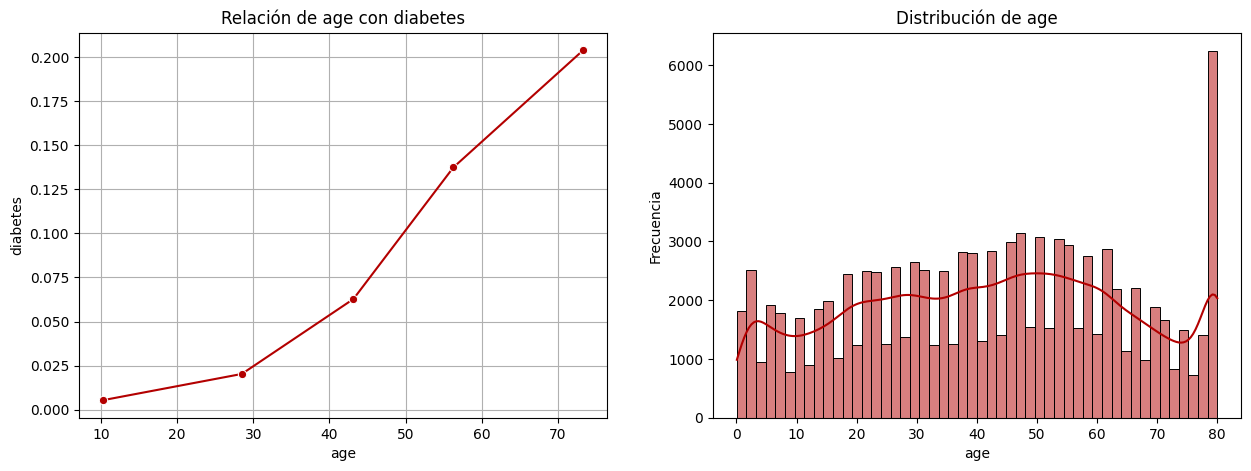

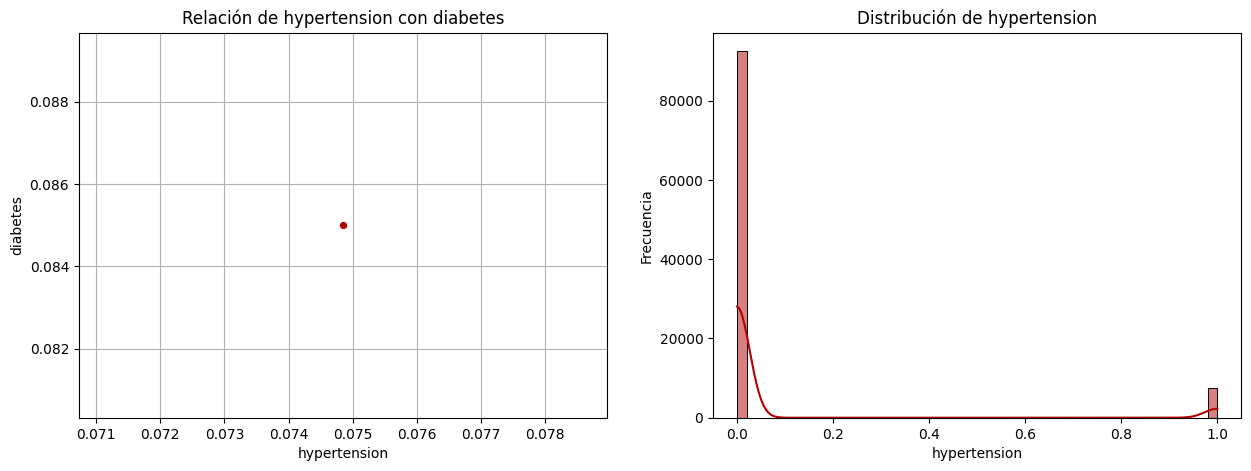

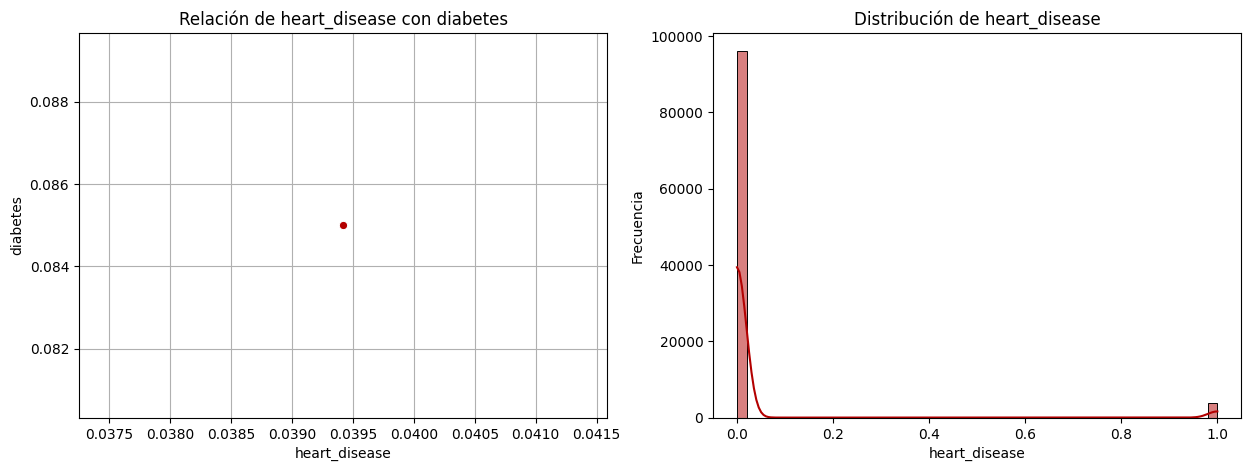

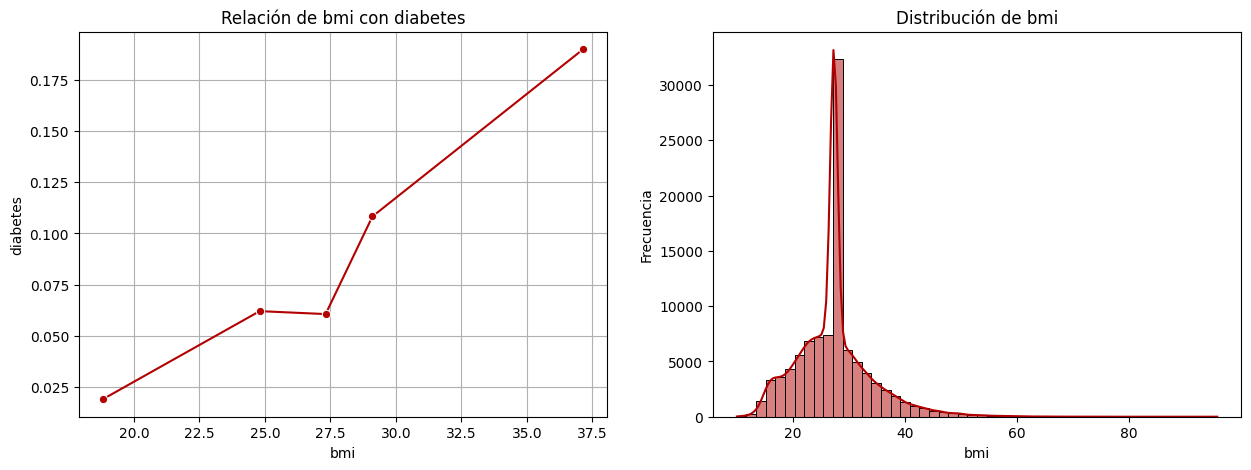

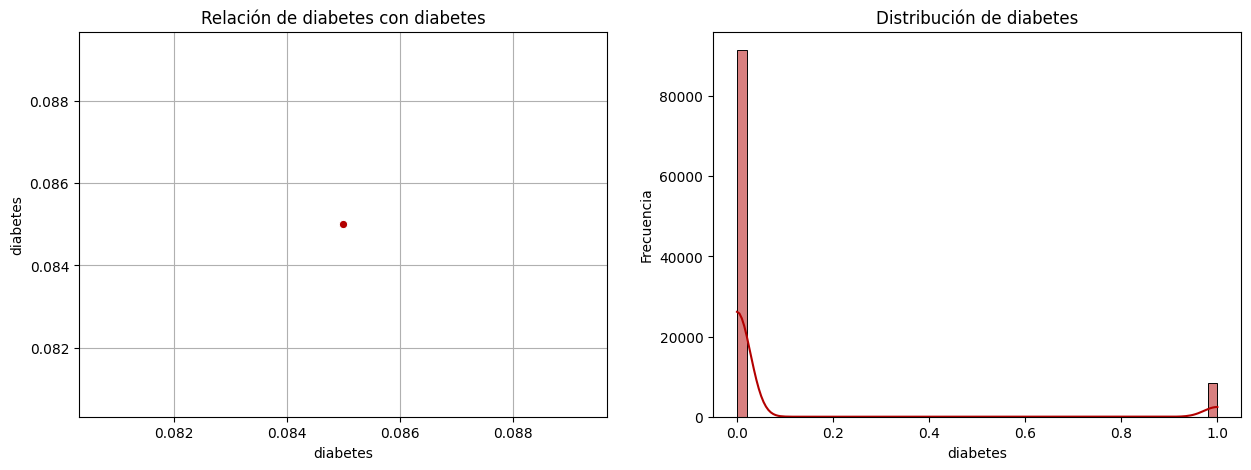

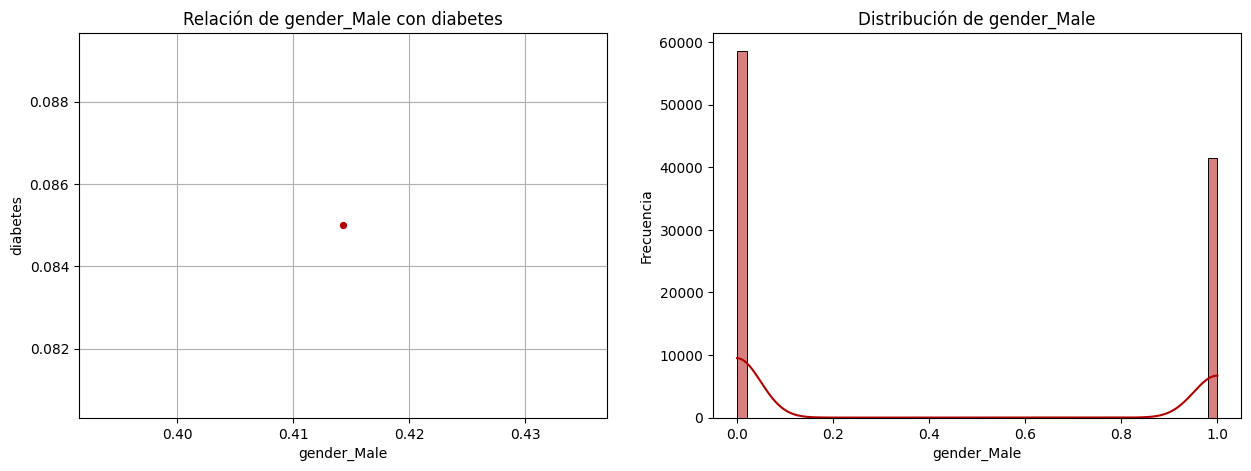

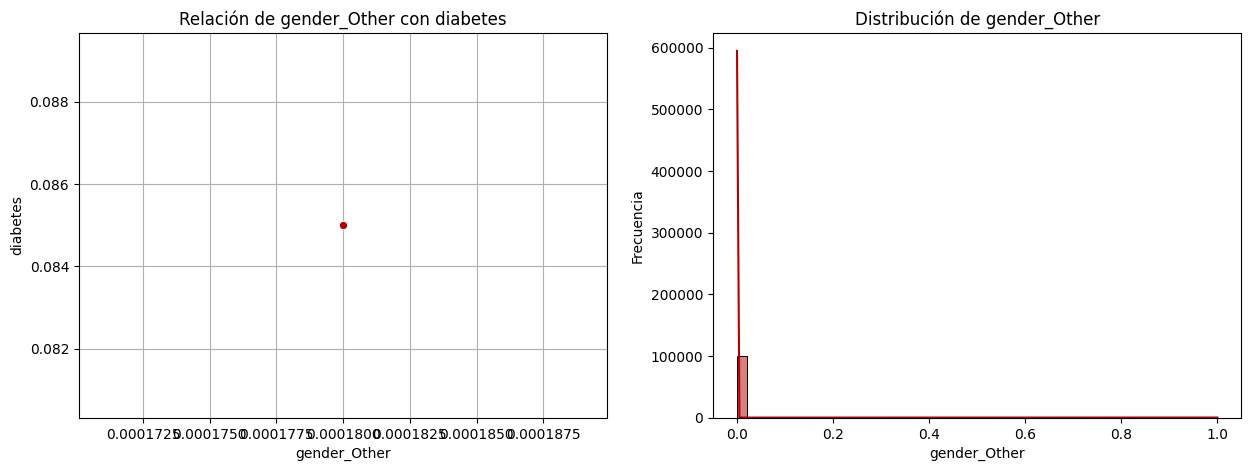

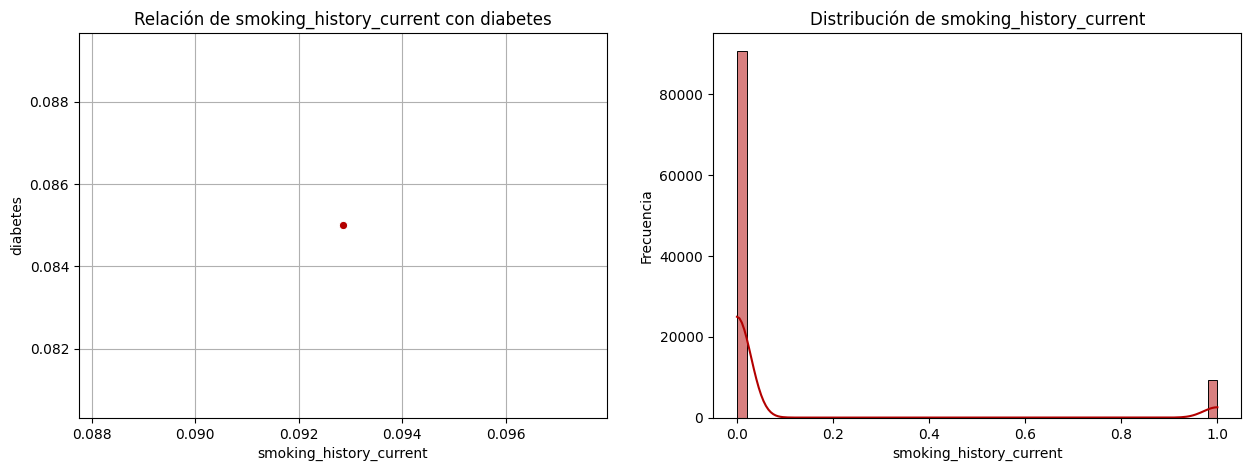

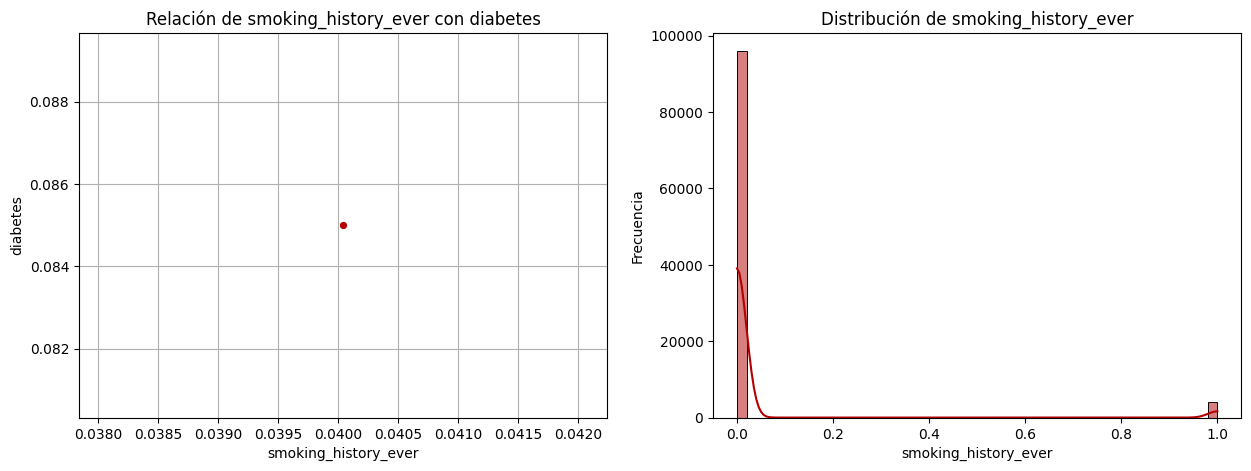

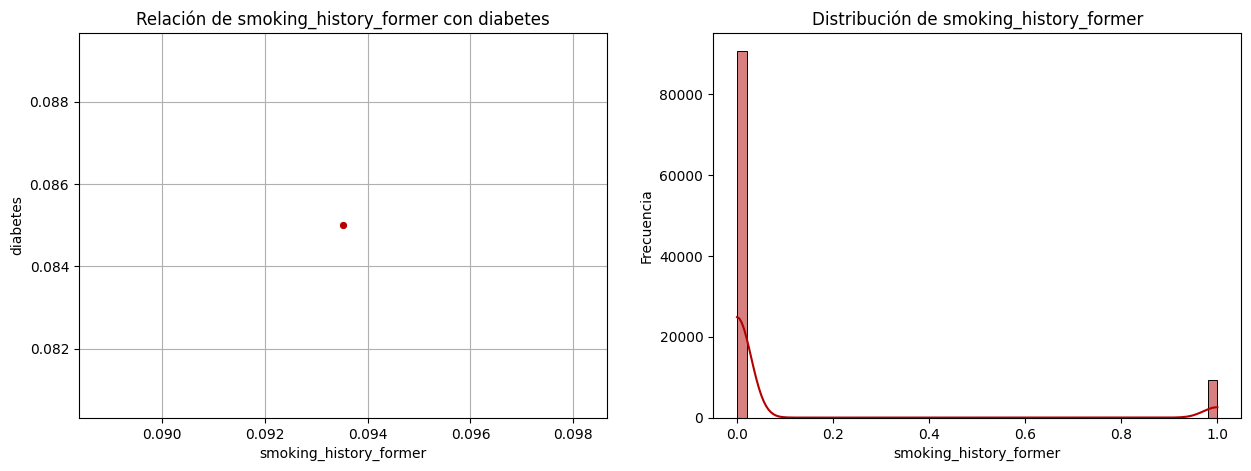

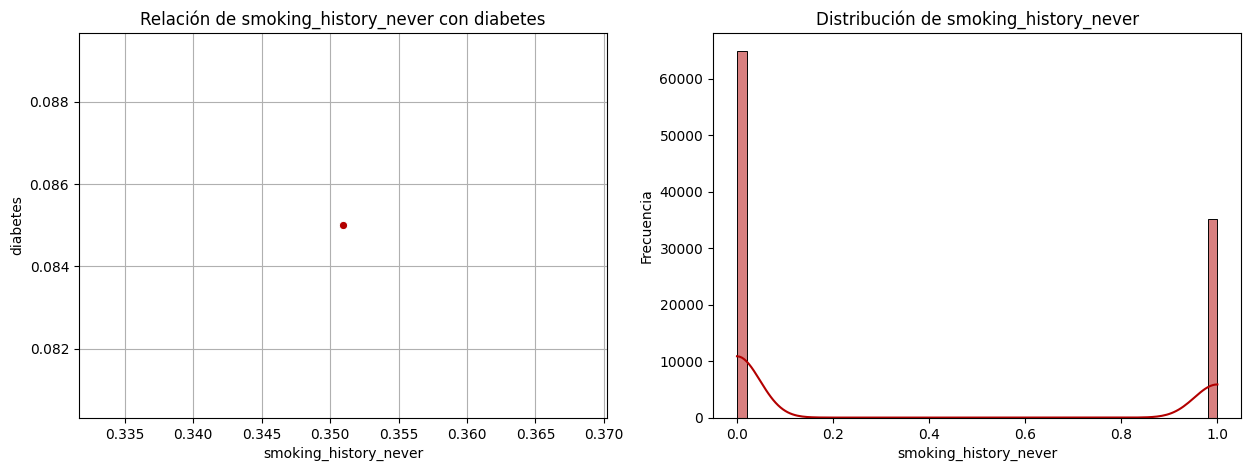

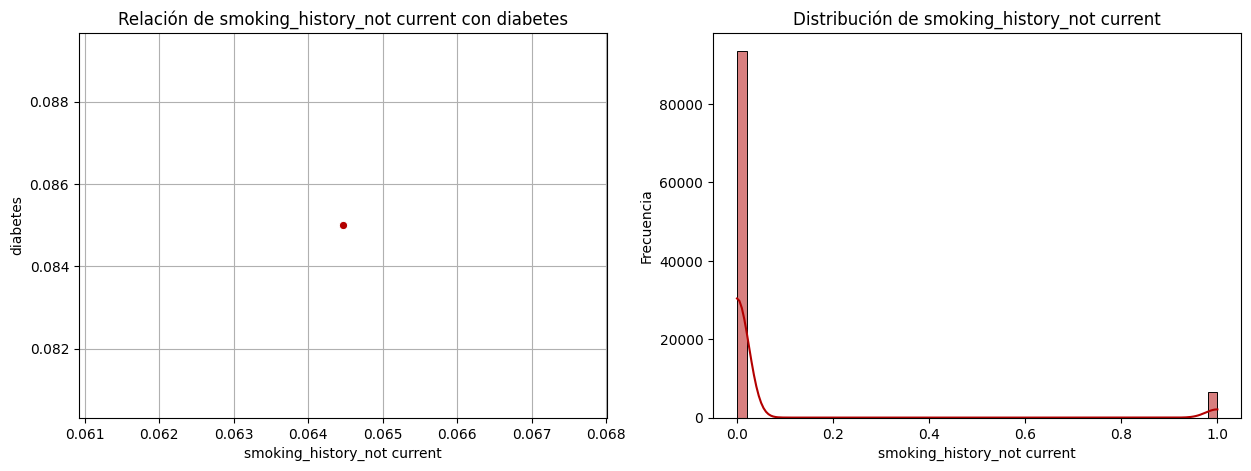

In [1065]:
bivariado(df)

---

### **Modelo**

Se pide que el modelo tenga: 

test set: 20%
random_state: 42

##### Correlación

In [1066]:
df.corr()['diabetes'].sort_values(ascending=False)

diabetes                       1.000000
age                            0.258008
bmi                            0.214357
hypertension                   0.197823
heart_disease                  0.171727
smoking_history_former         0.097917
gender_Male                    0.037666
smoking_history_never          0.027267
smoking_history_ever           0.024080
smoking_history_not current    0.020734
smoking_history_current        0.019606
gender_Other                  -0.004090
Name: diabetes, dtype: float64

In [1067]:
df.drop('gender_Other', axis=1, inplace=True)

In [1068]:
df.corr()['diabetes'].sort_values(ascending=False)

diabetes                       1.000000
age                            0.258008
bmi                            0.214357
hypertension                   0.197823
heart_disease                  0.171727
smoking_history_former         0.097917
gender_Male                    0.037666
smoking_history_never          0.027267
smoking_history_ever           0.024080
smoking_history_not current    0.020734
smoking_history_current        0.019606
Name: diabetes, dtype: float64

---

## **Modelos**

## Arboles de decisión

Árbol con `max_depth`= 2 

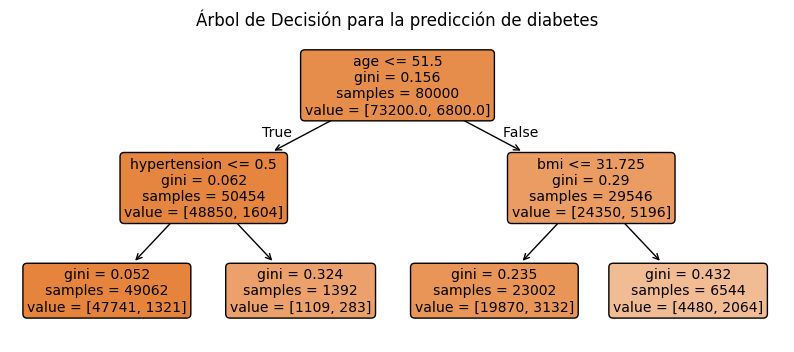

AUC Tree: 0.7585739312118289


In [1069]:
model = DecisionTreeClassifier(max_depth=2, random_state=42)
model.fit(X_train, y_train)

predicciones_tree = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_score=predicciones_tree, y_true=y_test)

plt.figure(figsize=(10, 4)) 
plot_tree(model, feature_names=X.keys(), filled=True, rounded=True)
plt.title("Árbol de Decisión para la predicción de diabetes")
plt.show()
print("AUC Tree:", auc_score)

En este árbol de decisión se puede observar que la edad es la variable más determinante para la predicción de diabetes. A partir de los 51.5 años, el modelo realiza una mejor separación entre clases. Posteriormente, se identifican la hipertensión y el índice de masa corporal (BMI) como variables muy relevantes para la predicción. Con esta estructura, el árbol alcanza un AUC aceptable de `0.7585`, lo que indica una buena capacidad para distinguir entre clases.

---

## Mejor Árbol

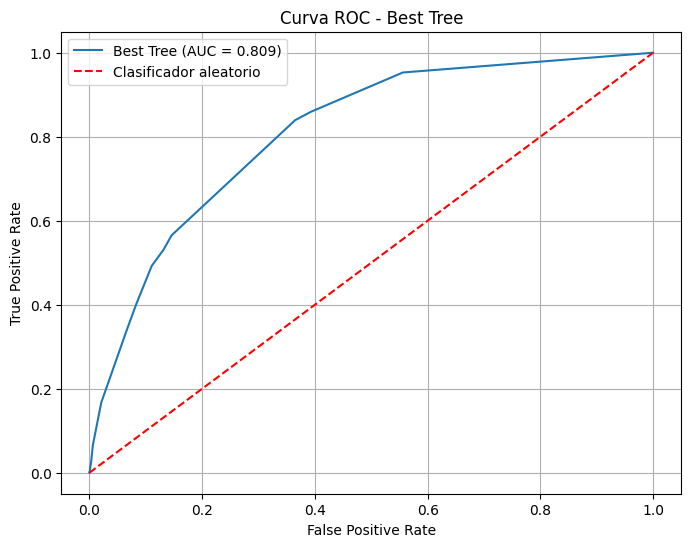

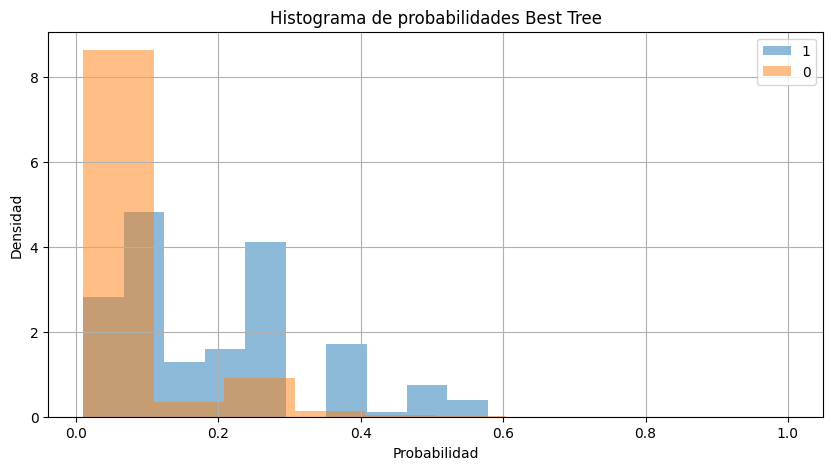

AUC Best tree: 0.8094773224043715


In [1070]:
predicciones_best= bestTree(X_train,y_train,X_test,y_test)

En este caso se buscó mejorar el AUC del primer árbol, y se logró con éxito. El modelo pudo distinguir entre clases con un incremento de casi 0.05 respecto al primer resultado. Con esto, podemos concluir que ambos modelos lograron una buena capacidad de distinción de clases, obteniendo finalmente un AUC de `0.8094` con el mejor árbol de decisión.

---

## Random Forest

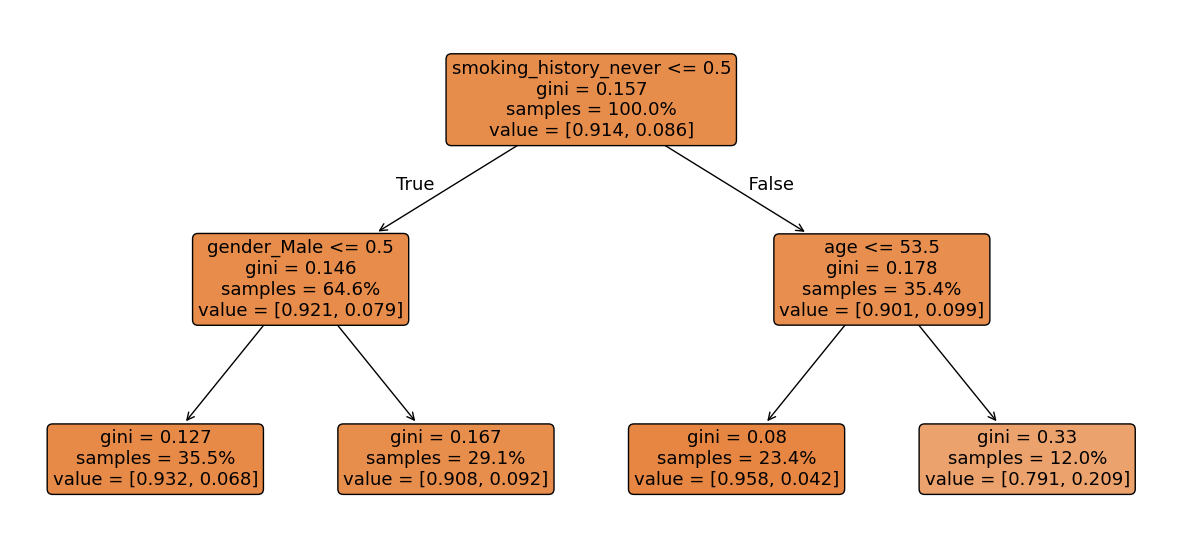

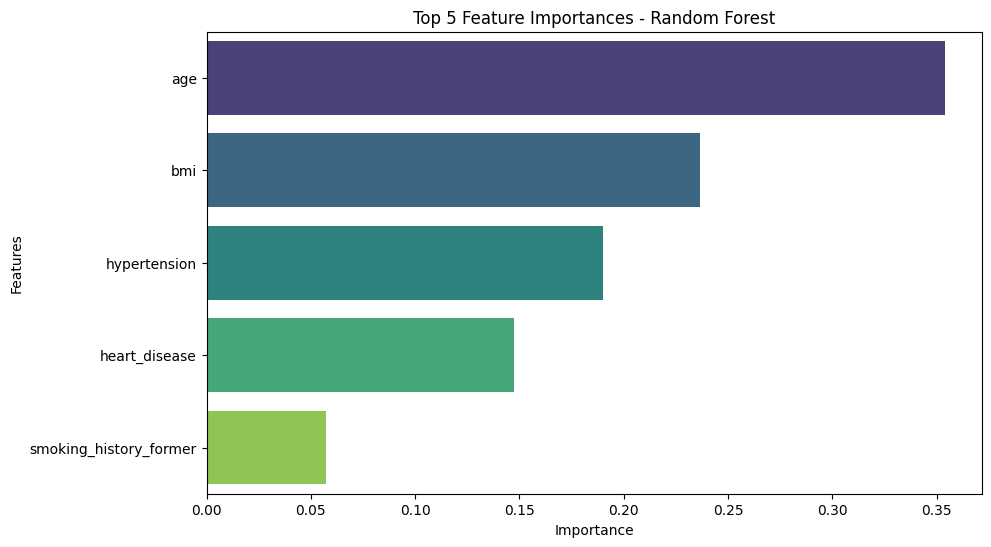

AUC Random Forest: 0.8244



,variables,importancia
0,age,0.353800
3,bmi,0.236709
1,hypertension,0.190166
2,heart_disease,0.147247
8,smoking_history_former,0.057169


In [1073]:
rf = RandomForestClassifier(max_depth=2, n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train)

plt.figure(figsize=(15, 7))
plot_tree(rf.estimators_[0], feature_names=X.columns, filled=True, rounded=True, proportion=True);
plt.show()

predicciones_rf = rf.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, predicciones_rf)

importancias = pd.DataFrame({
    'variables': X.columns,
    'importancia': rf.feature_importances_  
})

plt.figure(figsize=(10, 6))
importancias.sort_values('importancia', ascending=False, inplace=True)
sns.barplot(x='importancia', y='variables', data=importancias.head(5), palette='viridis')
plt.title('Top 5 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

print(f"AUC Random Forest: {auc:.4f}")

importancias.sort_values('importancia', ascending=False, inplace=True)
print()
importancias.head(5)


Se construyó un modelo de Random Forest con el objetivo de mejorar el AUC. En este modelo se observó que la variable más importante fue el historial de fumadores, seguida por la edad y el género. Estos factores resultaron ser importantes para predecir si una persona tiene diabetes o no.
El modelo logró una mejora significativa respecto al mejor árbol anterior, alcanzando un AUC de `0.8244`, lo que indica una excelente capacidad de distinción de las clases. Además se observa en el features importance , que la variable que más importancia tiene en la diabetes es la edad.

---

## Mejor Random Forest

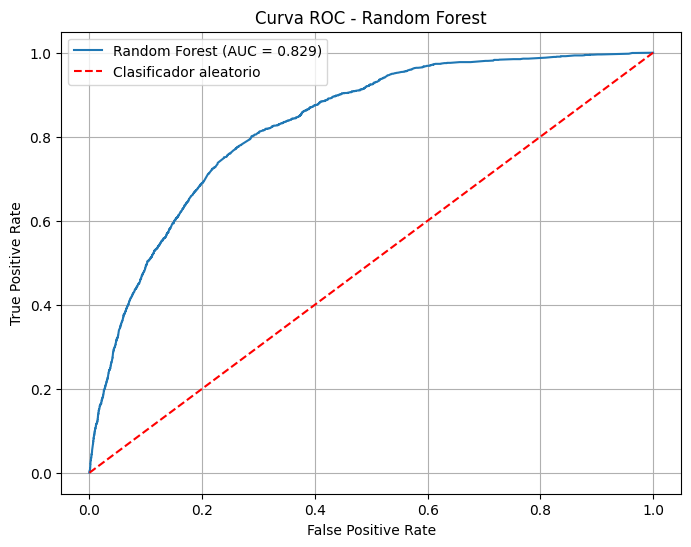

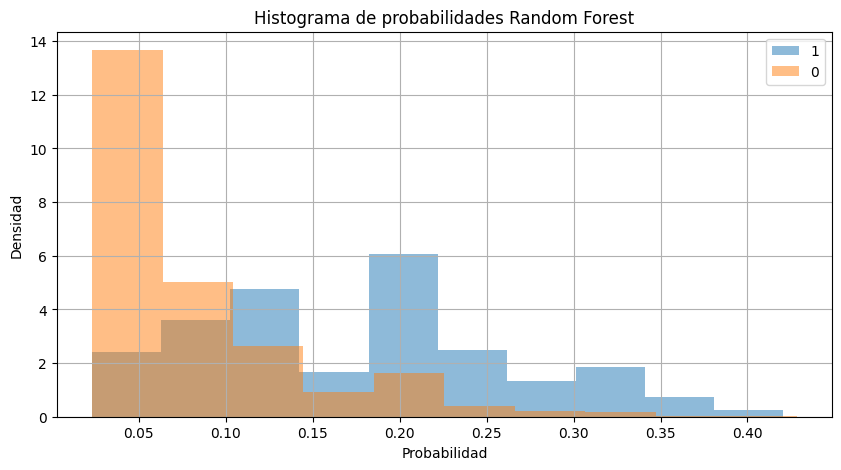

AUC Random Forest: 0.8294710382513661



In [ ]:
predicciones_bestrf= randomforest(X_train,y_train,X_test,y_test)

Se intentó mejorar el modelo anterior, aunque no se logró una mejora significativa. Si bien el resultado fue muy bueno, no se observa una diferencia considerable respecto al primer Random Forest. Considero que, ajustando mejor los parámetros, podría obtenerse un desempeño aún mayor; sin embargo, debido a limitaciones computacionales, el modelo se mantendrá con este muy buen resultado, aunque sin certeza de haber alcanzado el óptimo. El AUC obtenido fue de `0.8294`, indicando que tuvo una muy buena distinción de clases.

---

## Gradient Boosting

### XGBoost

[0]	validation_0-auc:0.81687


c:\Users\ppmel\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [01:20:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-auc:0.83696
[200]	validation_0-auc:0.83409
[300]	validation_0-auc:0.83170
[400]	validation_0-auc:0.83046
[500]	validation_0-auc:0.82867
[600]	validation_0-auc:0.82744
[700]	validation_0-auc:0.82607
[800]	validation_0-auc:0.82401
[900]	validation_0-auc:0.82309
[999]	validation_0-auc:0.82126
AUC XGBoost: 0.8212604146576663


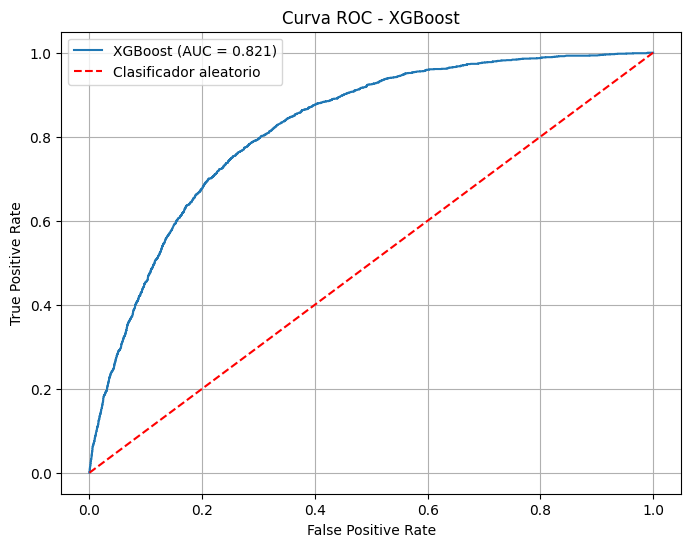

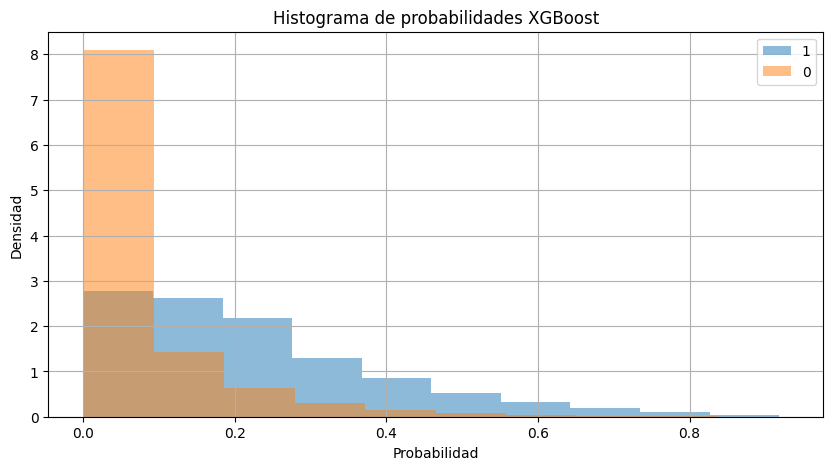

In [ ]:
proba_xgboost= xgboost(X_train, y_train, X_test, y_test)

---

#### LightGBM

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	training's auc: 0.840872	training's binary_logloss: 0.225582	valid_1's auc: 0.839397	valid_1's binary_logloss: 0.226495
AUC LightGBM: 0.8393972516875602


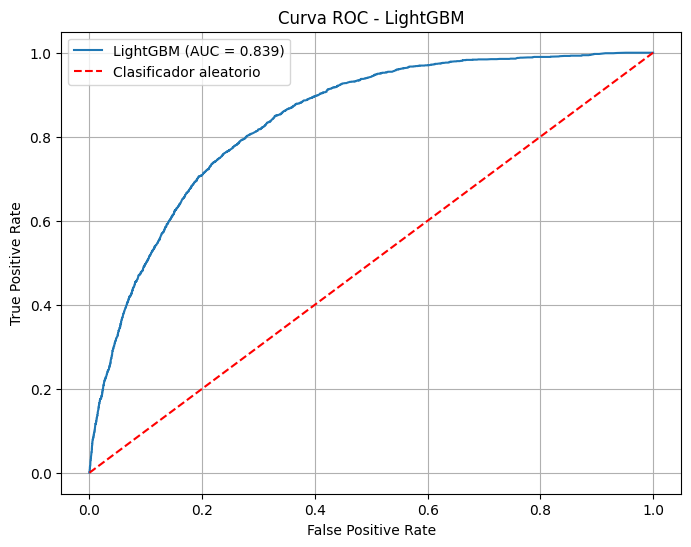

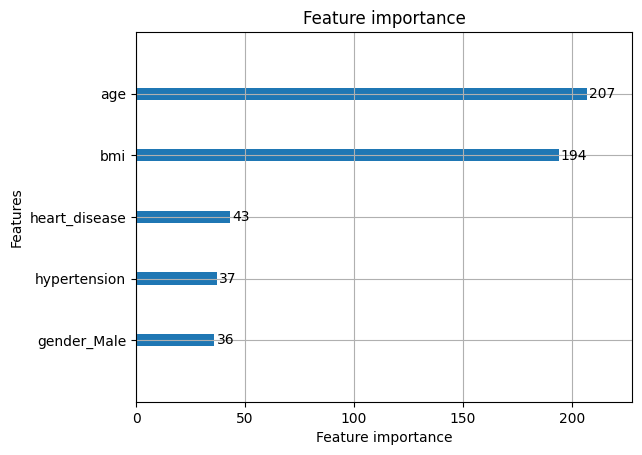

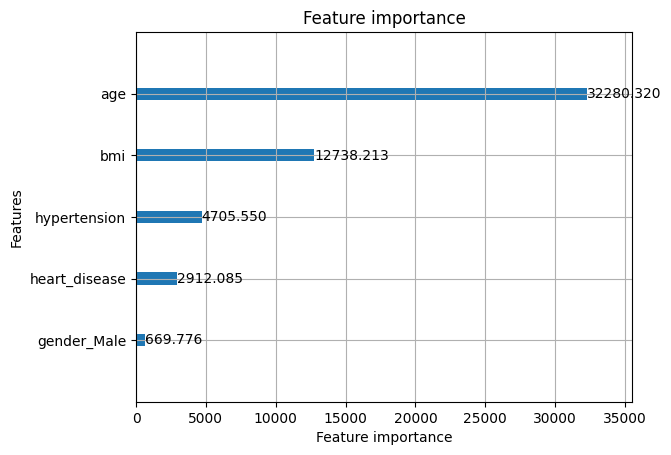

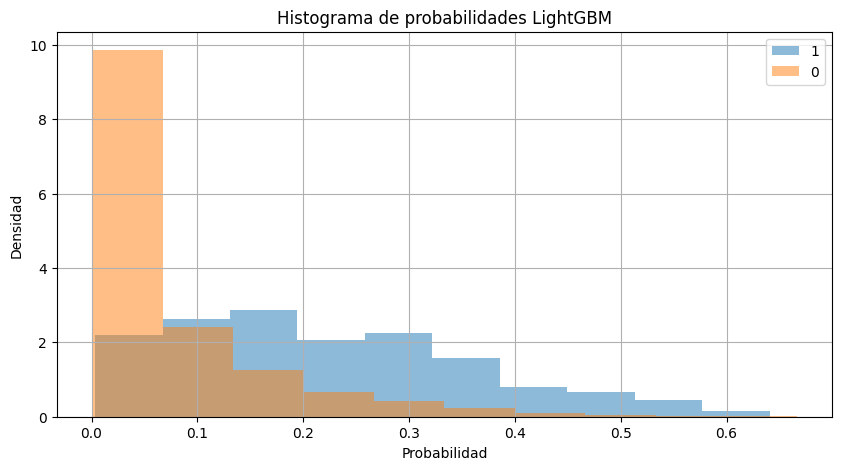

In [ ]:
proba_lightgbm=lightgbm(X_train, y_train, X_test, y_test)

---

### CatBoost

0:	test: 0.7943872	best: 0.7943872 (0)	total: 19.4ms	remaining: 3m 13s
100:	test: 0.8395209	best: 0.8395871 (98)	total: 1.91s	remaining: 3m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8395871263
bestIteration = 98

Shrink model to first 99 iterations.
AUC CatBoost: 0.8395871263259402


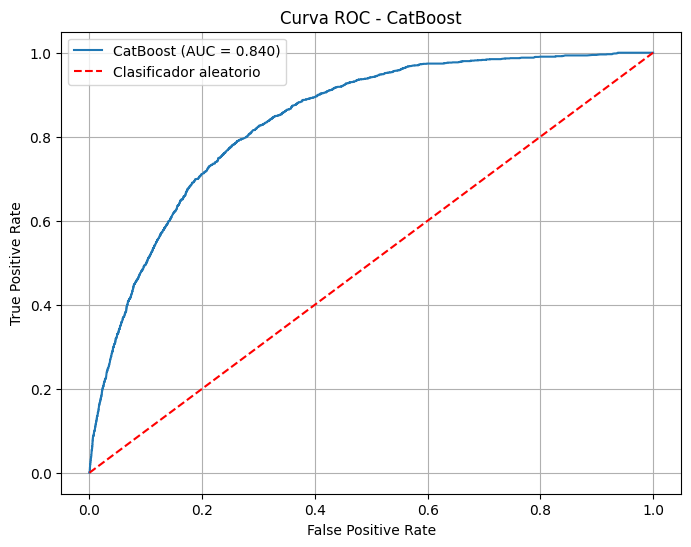

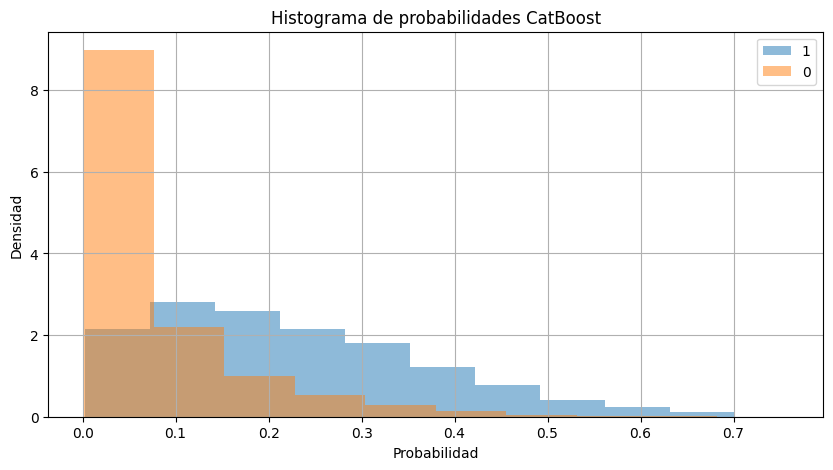

In [ ]:
proba_catboost= catboost(X_train, y_train, X_test, y_test)

Se construyeron tres modelos de Gradient Boosting, donde se observó que no hubo una gran diferencia en el desempeño entre LightGBM y CatBoost. Sin embargo, CatBoost, al estar optimizado para trabajar con variables categóricas, logró superar a los otros dos modelos. Este modelo presentó una muy buena capacidad de distinción entre clases, siendo el mejor de los tres. Por otro lado , XGBoost quedó con un resultado muy bajo a comparación de los dos , queda ver si mejorando los parametros pudiera mejorar su predicción para la diabetes. El mejor AUC fue el de CatBoost con un `0.8395`.

---

### AUC de los Modelos:

In [ ]:
AUC = pd.DataFrame({
    'D. Tree' : [roc_auc_score(y_true=y_test, y_score=predicciones_tree)],
    'Best Tree': [roc_auc_score(y_true=y_test, y_score=predicciones_best)],
    'Random Forest': [roc_auc_score(y_true=y_test, y_score=predicciones_rf)],
    'Best Random Forest': [roc_auc_score(y_true=y_test, y_score=predicciones_bestrf)],
    'XGBoost': [roc_auc_score(y_true=y_test, y_score=proba_xgboost)],
    'LightGBM': [roc_auc_score(y_true=y_test, y_score=proba_lightgbm)],
    'CatBoost' :  [roc_auc_score(y_true=y_test, y_score=proba_catboost)],
},index=['AUC'])
AUC

,D. Tree,Best Tree,Random Forest,Best Random Forest,XGBoost,LightGBM,CatBoost
AUC,0.758574,0.809477,0.824444,0.829471,0.82126,0.839397,0.839587


## Conclusión

Una vez sabiendo todos los resultados de los modelos, podemos observar que el que mejor distinción de clases tuvo , fue el de CatBoost, esto se debe a que maneja mejor las 